# Predicting survival on the Titanic

<b>*Piotr Skalski - 09.10.2017*</b>

# Table of Contents

* [1. Introduction](#introduction)
* [2. Importing dataset and preparation of data](#importing_dataset_and_preparation_of_data)
<br>
   * [2.1. Dataset import](#dataset_import)
   * [2.2. Let's try to summarize the Dataset](#lets_summarize_the_dataset)
   * [2.3. Data preprocessing and feature engineering](#data_preprocessing_and_feature_engineering)
<br>   
      * [2.3.1. Pclass](#pclass)
      * [2.3.2. Sex](#sex)
      * [2.3.3. Family Size](#family_size)
      * [2.3.4. Embarked](#embarked)
      * [2.3.5. Fare](#fare)
      * [2.3.6. Age](#age)
      * [2.3.7. Cabin](#cabin)
      * [2.3.8. Title](#title)
      * [2.3.9. Data Cleaning](#data_cleaning)
      * [2.3.10. Correlation Heatmap](#correlation_heatmap)
<br>      
* [3. Classification](#classification)
<br>
   * [3.1. Dataset preperation](#dataset_preperation)
   * [3.2. Decision Tree Classifier](#decision_tree_classifier)
   * [3.3. Random Forest Classifier](#random_forest_classifier)
   * [3.4. K Neighbors Classifier](#k_neighbors_classifier)
   * [3.2. Decision Tree Classifier](#decision_tree_classifier)

<img src='https://upload.wikimedia.org/wikipedia/commons/2/2a/Titanic_in_Southampton.jpg'>

## 1. Introduction
<a id="introduction"></a>

Not so long ago I got intrested in Machine Learning, set up Kaggle account and spend last few weeks studding script of other users. I feel it's high time for me, to try my skills in Titanic dataset competition. I will focus on data visualizations, but also try my best in predictiong survival of passengers. As I said, I am quitey new to Machine Learning, so I am grateful for any feedback and guidelines.

Lets import essential libraries and get started:

In [1]:
# scientific computing
import numpy as np
# data analysis
import pandas as pd
# missing values by columns
import missingno as msno

# using regular expression
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

## 2. Importing dataset and preparation of data
<a id="importing_dataset_and_preparation_of_data"></a>

### 2.1. Dataset import
<a id="dataset_import"></a>

In [2]:
# Importing the dataset
dataset_test = pd.read_csv('../00_Datasets/Titanic_test.csv', header = 0, dtype={'Age': np.float64})
dataset_train = pd.read_csv('../00_Datasets/Titanic_train.csv', header = 0, dtype={'Age': np.float64})
full_data = [dataset_test, dataset_train]

### 2.2. Let's try to summarize the Dataset
<a id="lets_summarize_the_dataset"></a>

In [3]:
dataset_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dataset_train.info()
print('_'*40)
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

<b>NOTE:</b> Let's use "Missingno" package, which is a most useful and convenient tool in visualising missing values in the dataset.

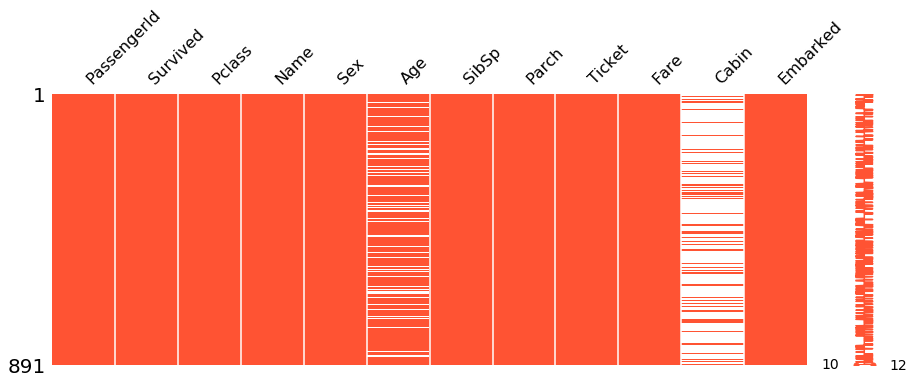

In [5]:
msno.matrix(df=dataset_train, figsize=(15, 5), color=(255/255, 83/255, 51/255))

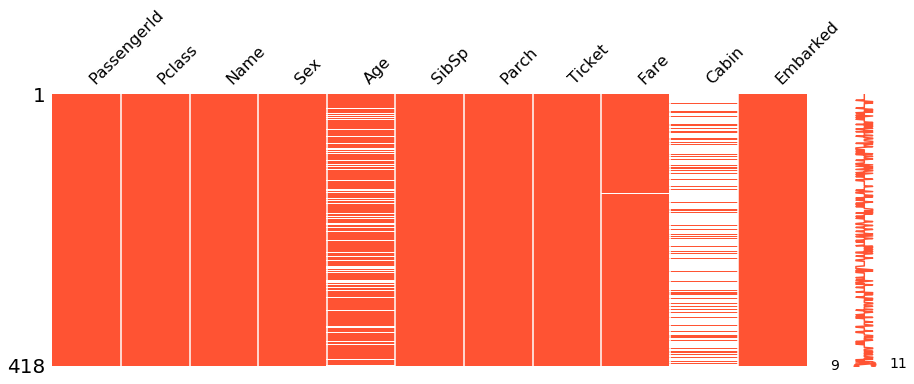

In [6]:
msno.matrix(df=dataset_test, figsize=(15, 5), color=(255/255, 83/255, 51/255))

<b>NOTE:</b> Right away we see that data set contains columns that require correcting. Cabin and Age features are incomplete. Moreover five features are strings and aren't really useful in current form. Our job is to preprocess data and extract from those columns essential informations.

### 2.3. Data preprocessing and feature engineering
<a id="data_preprocessing_and_feature_engineering"></a>

<b>NOTE:</b> This part of script is based on <a href="https://www.kaggle.com/sinakhorami/titanic-best-working-classifier">Titanic best working Classifier</a> by Sina.

### 2.3.1. Pclass
<a id="pclass"></a>

<b>NOTE:</b> There are no missing values on this feature and it is already a numerical value. Let's check it's impact on our train set:

In [7]:
print (dataset_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [8]:
passengers_by_class = dataset_train[['Pclass', 'Survived']].groupby(['Pclass']).count()
passengers_by_class_sur = dataset_train[['Pclass', 'Survived']].groupby(['Pclass']).sum()

trace1 = go.Bar(
    x = ['First', 'Second', 'Third'],
    y = passengers_by_class_sur['Survived'].tolist(),
    name='Survived',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = ['First', 'Second', 'Third'],
    y = (passengers_by_class['Survived'] - passengers_by_class_sur['Survived']).tolist(),
    name='Drowned',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title = 'Survival vs Class',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'Number of passengers'),
    xaxis = dict(title= 'Class')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 2.3.2. Sex
<a id="sex"></a>

<b>NOTE:</b> This feature is also complete but this time it is not a numerical value. We will need to conduct feature mapping.

In [9]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [10]:
print (dataset_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

   Sex  Survived
0    0  0.742038
1    1  0.188908


In [11]:
passengers_by_sex = dataset_train[['Sex', 'Survived']].groupby(['Sex']).count()
passengers_by_sex_sur = dataset_train[['Sex', 'Survived']].groupby(['Sex']).sum()

trace1 = go.Bar(
    x = ['Femail', 'Mail'],
    y = passengers_by_sex_sur['Survived'].tolist(),
    name='Survived',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = ['Femail', 'Mail'],
    y = (passengers_by_sex['Survived'] - passengers_by_sex_sur['Survived']).tolist(),
    name='Drowned',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title = 'Survival vs Sex',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'Number of passengers'),
    xaxis = dict(title= 'Sex')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 2.3.3. Family Size
<a id="family_size"></a>

<b>NOTE:</b> Using the number of siblings/spouse and the number of children/parents we can create new feature called Family Size.

In [12]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (dataset_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [13]:
family_labels = dataset_train.sort_values("FamilySize")["FamilySize"].unique()
family = dataset_train[['FamilySize', 'Survived']].groupby(['FamilySize']).count()
family_sur = dataset_train[['FamilySize', 'Survived']].groupby(['FamilySize']).sum()

trace1 = go.Bar(
    x = family_labels.tolist(),
    y = family_sur['Survived'].tolist(),
    name='Survived',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = family_labels.tolist(),
    y = (family['Survived'] - family_sur['Survived']).tolist(),
    name='Drowned',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

trace3 = go.Scatter(
    x = family_labels.tolist(),
    y = (family_sur['Survived'] * 100 / family['Survived']).tolist(),
    name='Survival %',
    mode = 'lines+markers',
    yaxis='y2'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = 'Survival vs Size of Family',
    width=1000,
    height=600,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(
        title= 'Number of passengers',
        anchor = 'x',
        rangemode='tozero'
    ),
    xaxis = dict(title= 'Size of Family'),
    
    yaxis2=dict(
        title='Survival %',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 9.8
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<b>NOTE:</b> It seems that new feature has a good effect on our prediction, but let's go further and categorize people to check whether they are alone in this ship or not.

In [14]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (dataset_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


### 2.3.4. Embarked
<a id="embarked"></a>

<b>NOTE:</b> The embarked feature contains information about port of embarkation, unfortunately it has some missing values. We try to fill those with the most occurred value ( 'S' ). Next we will map string values into numeric ones.

In [15]:
for dataset in full_data:
    # Filling missing values with most occurred one
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
print (dataset_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

   Embarked  Survived
0         0  0.339009
1         1  0.553571
2         2  0.389610


### 2.3.5. Fare
<a id="fare"></a>

<b>NOTE:</b> Fare feature also has some missing value. We replace those values with the median, then we categorize it into 4 ranges and map them into numerical categories.

In [16]:
for dataset in full_data:
    # Fill NA/NaN values using the specified method
    dataset['Fare'] = dataset['Fare'].fillna(dataset_train['Fare'].median())
    dataset['CategoricalFare'] = pd.qcut(dataset_train['Fare'], 4)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
print (dataset_train[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean())

   Fare  Survived
0     0  0.197309
1     1  0.308756
2     2  0.445415
3     3  0.581081


In [17]:
fare = dataset_train[['Fare', 'Survived']].groupby(['Fare']).count()
fare_sur = dataset_train[['Fare', 'Survived']].groupby(['Fare']).sum()

trace1 = go.Bar(
    x = ['Low', 'Medium', 'High', 'Premium'],
    y = fare_sur['Survived'].tolist(),
    name='Survived',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = ['Low', 'Medium', 'High', 'Premium'],
    y = (fare['Survived'] - fare_sur['Survived']).tolist(),
    name='Drowned',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title = 'Survival vs Fare',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'Number of passengers'),
    xaxis = dict(title= 'Fare')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 2.3.6. Age
<a id="age"></a>

<b>NOTE:</b> We have plenty of missing values in this feature. We fill blanks with random numbers between (mean - std) and (mean + std), then we categorize age into 5 range  and map them into numerical categories.

In [18]:
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    dataset['CategoricalAge'] = pd.cut(dataset_train['Age'], 5)
    
print (dataset_train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.508621
1   (16.0, 32.0]  0.361364
2   (32.0, 48.0]  0.364706
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


C:\Users\AFGHAN92\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



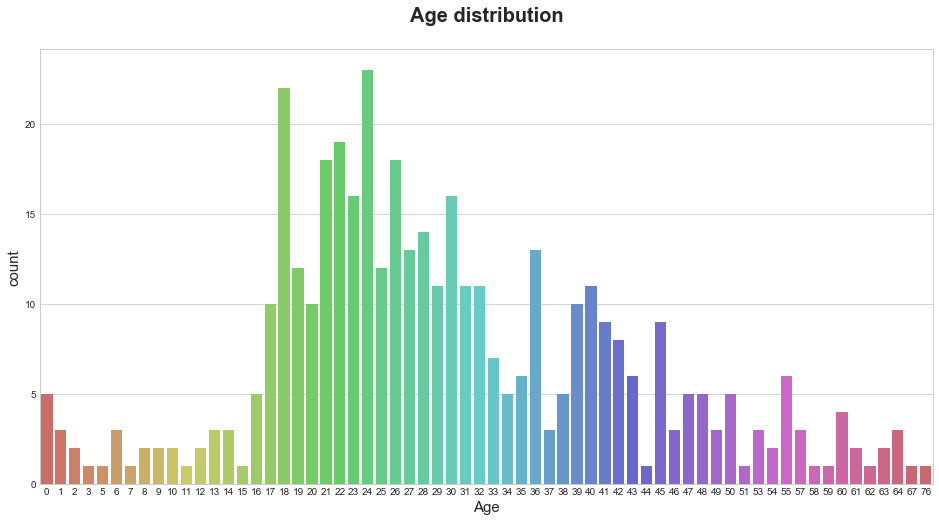

In [19]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Age distribution', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Number of people', fontsize=15)
plt.ylabel('Age', fontsize=15)
sns.countplot(x="Age", data=dataset_test, palette="hls");
plt.show()

In [20]:
for dataset in full_data:
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

In [21]:
age = dataset_train[['Age', 'Survived']].groupby(['Age']).count()
age_sur = dataset_train[['Age', 'Survived']].groupby(['Age']).sum()

trace1 = go.Bar(
    x = ['[0 - 16]', '(16 - 32]', '(32 - 48]', '(48 - 64]', '(64 - ...]'],
    y = age_sur['Survived'].tolist(),
    name='Survived',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = ['[0 - 16]', '(16 - 32]', '(32 - 48]', '(48 - 64]', '(64 - ...]'],
    y = (age['Survived'] - age_sur['Survived']).tolist(),
    name='Drowned',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)
trace3 = go.Scatter(
    x = ['[0 - 16]', '(16 - 32]', '(32 - 48]', '(48 - 64]', '(64 - ...]'],
    y = (age_sur['Survived'] * 100 / age['Survived']).tolist(),
    name='Survival %',
    mode = 'lines+markers',
    yaxis='y2'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='stack',
    title = 'Survival vs Age',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'Number of passengers'),
    xaxis = dict(title= 'Age'),
    yaxis2=dict(
        title='Survival %',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 11.2
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 2.3.7. Cabin
<a id="cabin"></a>

<b>NOTE:</b> Feature that tells whether a passenger had a cabin on the Titanic.

In [22]:
for dataset in full_data:
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

### 2.3.8. Title
<a id="title"></a>

<b> NOTE: </b> Lastly we will use Name feature to create new one - Title. We will use short funtion to extract titles from name strings and transform them into numerical categorical values.

In [23]:
# Short function to extruct titles 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [24]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [48]:
title = dataset_train[['Title', 'Survived']].groupby(['Title']).count()
title_sur = dataset_train[['Title', 'Survived']].groupby(['Title']).sum()

trace1 = go.Bar(
    x = ['Mr', 'Miss', 'Mrs', 'Master', 'Rare'],
    y = title_sur['Survived'].tolist(),
    name='Survived',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
   x = ['Mr', 'Miss', 'Mrs', 'Master', 'Rare'],
    y = (title['Survived'] - title_sur['Survived']).tolist(),
    name='Drowned',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)
trace3 = go.Scatter(
    x = ['Mr', 'Miss', 'Mrs', 'Master', 'Rare'],
    y = (title_sur['Survived'] * 100 / title['Survived']).tolist(),
    name='Survival %',
    mode = 'lines+markers',
    yaxis='y2'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='stack',
    title = 'Survival vs Title',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'Number of passengers'),
    xaxis = dict(title= 'title'),
    yaxis2=dict(
        title='Survival %',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 15.6
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 2.3.9. Data Cleaning
<a id="data_cleaning"></a>

In [25]:
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch']

dataset_train = dataset_train.drop(drop_elements, axis = 1)
dataset_train = dataset_train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

dataset_test = dataset_test.drop(drop_elements, axis = 1)
dataset_test = dataset_test.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

print (dataset_train.head(10))

train = dataset_train.values
test  = dataset_test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  FamilySize  IsAlone  Has_Cabin  \
0         0       3    1    1     0         0           2        0          0   
1         1       1    0    2     3         1           2        0          1   
2         1       3    0    1     1         0           1        1          0   
3         1       1    0    2     3         0           2        0          1   
4         0       3    1    2     1         0           1        1          0   
5         0       3    1    1     1         2           1        1          0   
6         0       1    1    3     3         0           1        1          1   
7         0       3    1    0     2         0           5        0          0   
8         1       3    0    1     1         0           3        0          0   
9         1       2    0    0     2         1           2        0          0   

   Title  
0      1  
1      3  
2      2  
3      3  
4      1  
5      1  
6      1  
7      4  
8      3 

### 2.3.10. Correlation Heatmap
<a id="correlation_heatmap"></a>

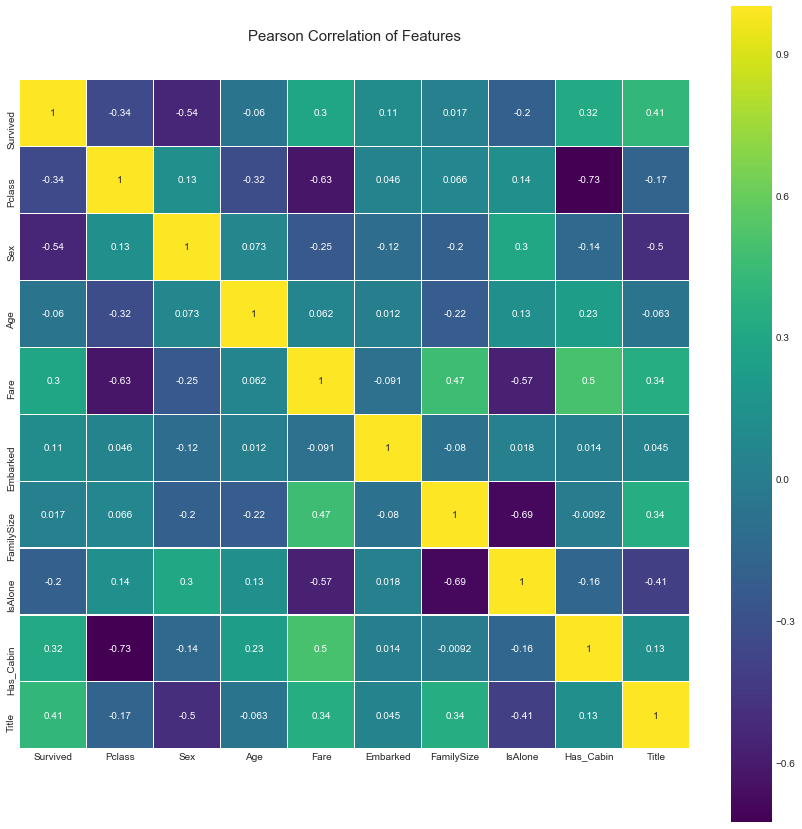

In [26]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(dataset_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## 3. Classification
<a id="classification"></a>

### 3.1. Dataset preperation
<a id="dataset_preperation"></a>

In [27]:
y_train = dataset_train['Survived'].ravel()
X_train = dataset_train.drop(['Survived'], axis=1).values
X_test = dataset_test.values

### 3.2. Decision Tree Classifier
<a id="decision_tree_classifier"></a>

In [28]:
from sklearn.tree import DecisionTreeClassifier
classifier_DTC = DecisionTreeClassifier(criterion='gini', random_state = 0)
classifier_DTC.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [49]:
# Feature importances for Decision Tree Classifier
feature_importances_DTC = classifier_DTC.feature_importances_
feature_importances_DTC

array([ 0.08940103,  0.00695799,  0.05976639,  0.06210815,  0.03398398,
        0.1842836 ,  0.        ,  0.06016824,  0.50333061])

In [50]:
acc_DTC = round(classifier_DTC.score(X_train, y_train) * 100, 2)
acc_DTC

89.790000000000006

### 3.3. Random Forest Classifier
<a id="random_forest_classifier"></a>

In [36]:
from sklearn.ensemble import RandomForestClassifier
classifier_RFC = RandomForestClassifier(n_estimators = 500, warm_start = True, max_depth = 6, min_samples_leaf = 2, max_features = 'sqrt')
classifier_RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [51]:
feature_importances_RFC = classifier_RFC.feature_importances_
feature_importances_RFC

array([ 0.12580572,  0.27081188,  0.04340915,  0.05680013,  0.02774424,
        0.09122958,  0.01494195,  0.0676271 ,  0.30163024])

In [52]:
acc_RFC = round(classifier_RFC.score(X_train, y_train) * 100, 2)
acc_RFC

85.069999999999993

### 3.4. K Neighbors Classifier
<a id="k_neighbors_classifier"></a>

In [39]:
dataset_train.drop(['Survived'], axis=1).columns.values

array(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone',
       'Has_Cabin', 'Title'], dtype=object)

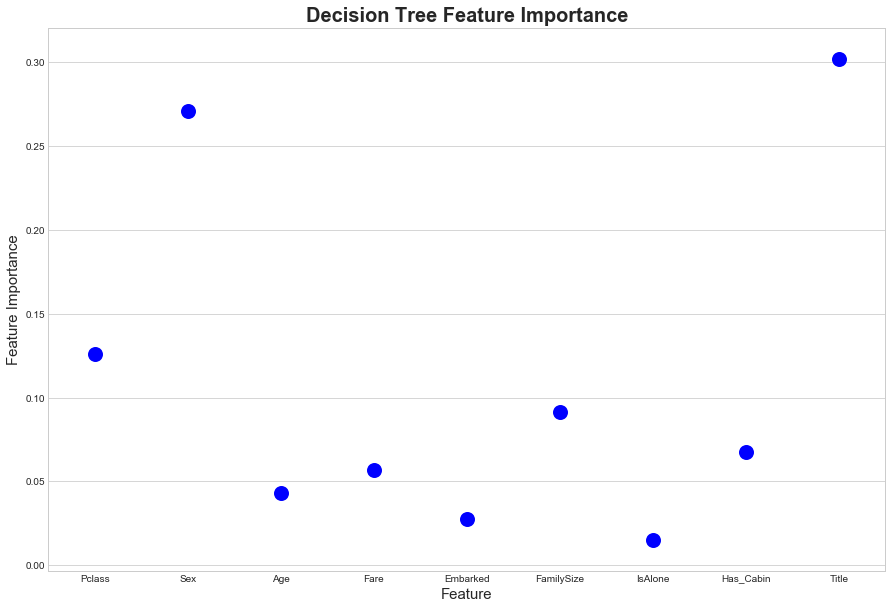

In [40]:
plt.figure()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
plt.title('Decision Tree Feature Importance', fontsize=20, fontweight='bold')
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)
sns.stripplot(dataset_train.drop(['Survived'], axis=1).columns.values, feature_importances_RFC, s = 15, color="blue")
plt.show()

## 5. Bibliography

1. https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
2. https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
3. https://en.wikipedia.org/wiki/Overfitting
4. https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook
5. https://www.kaggle.com/sinakhorami/titanic-best-working-classifier